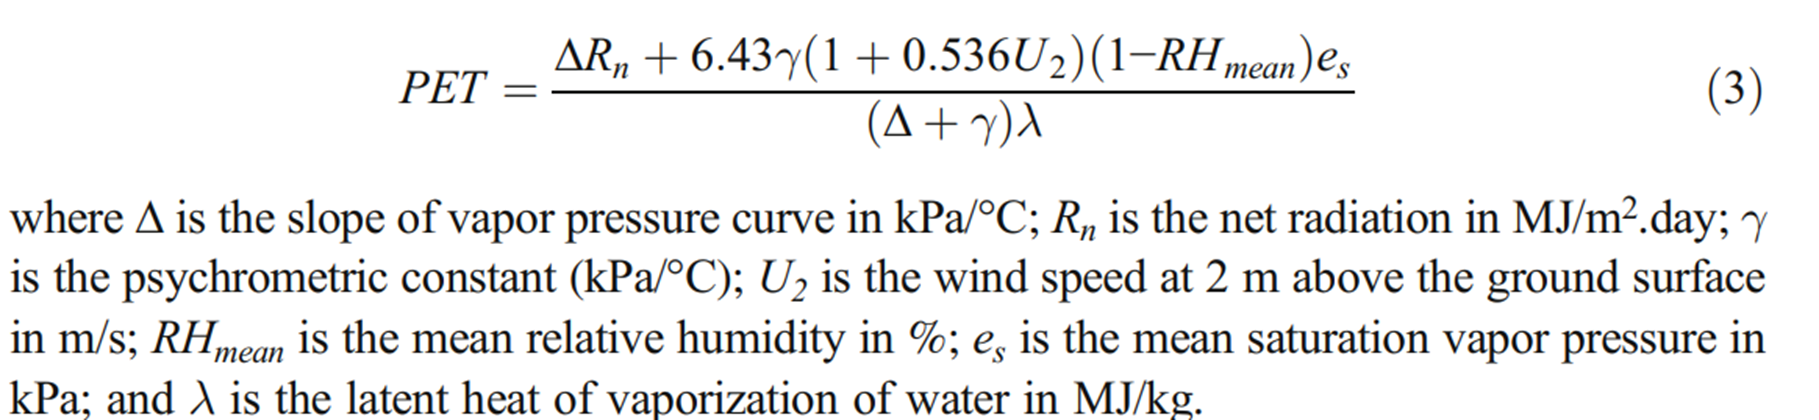

Units of PET is kg.m^(-2).day^(-1)

# Needed parameters

Air temperature in degrees, normal, max and min

Downwelling short Rs in MJ/(m^2.day)

Wind at 2 m [m/s], need to check height of the wind

Mean relative humidity in %

In [87]:
# Temperature in degrees
T = 20
T_max = 40
T_min = 10
Rs = 10 
RH_mean = 4
U_z =2 # usually 10 meters

In [2]:
# Problem with 
# Radiation and e_s

# Import packages

In [3]:
import math
import xarray as xr
import numpy as np

# Slope of vapor pressure
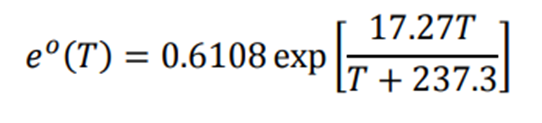
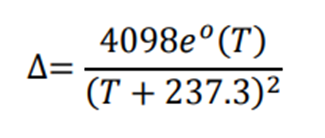
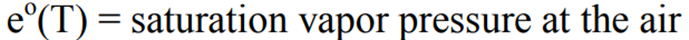
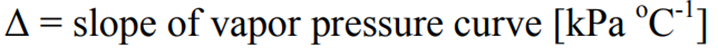
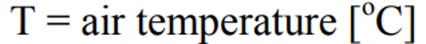

In [4]:
def e_0(T):
    e_0_result = 0.6108*math.exp(17.27*T/(T+237.3))
    return e_0_result
_delta = 4098*e_0(T)/(T+237.3)**2

# Net radiation
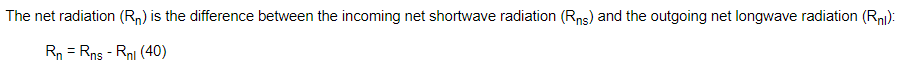

### Net shortwave radiation Rns
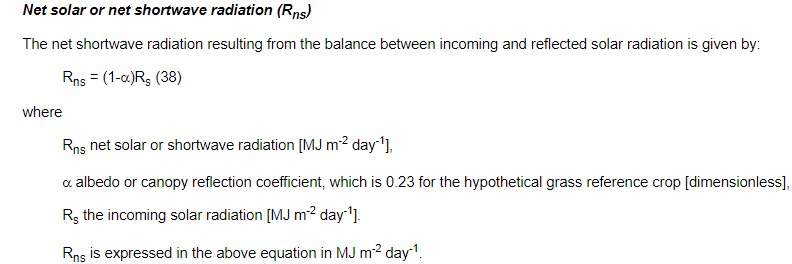

In [88]:
# from DANIEL A. VALLERO, in Fundamentals of Air Pollution (Fourth Edition), 2008
albedo = 0.035 # for the surface of water

Rns = (1 - albedo)*Rs

### Net longwave radiation Rnl
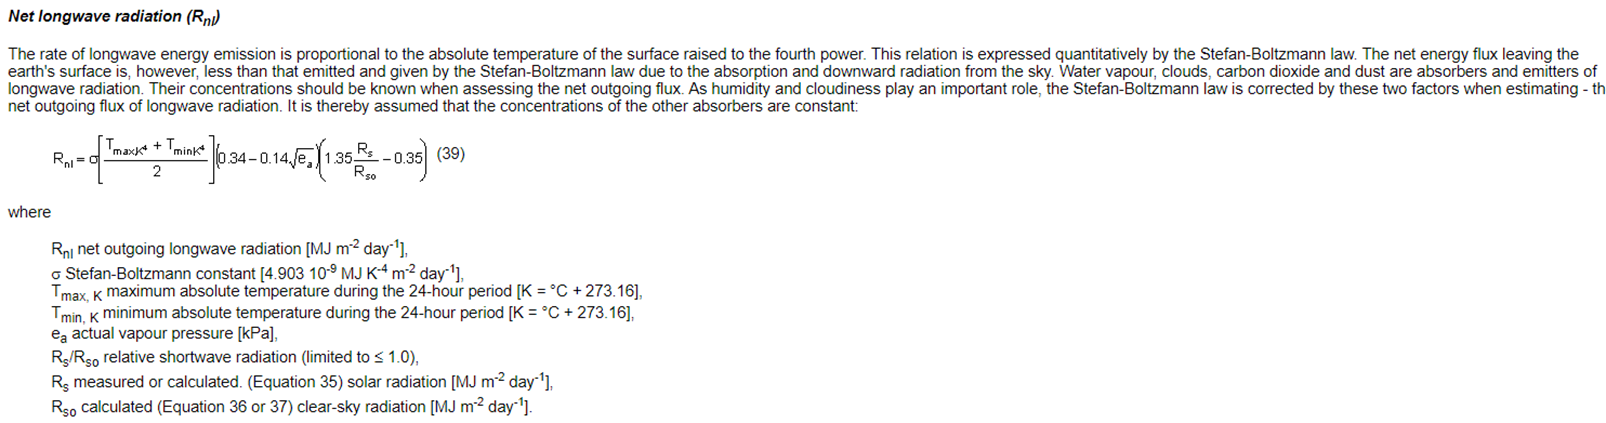

In [ ]:
Boltzman_constant = 4.903*10^(-9)
Rs0 = (0.75 + 2*10**(-5)*z_station_elevation)*R_a# depens on the station elevation above sea level [m] z_station_elevation and
# Ra, which depends on the month and latitude
e_a = RH*e_0(T)/(100)
Rnl = Boltzman_constant*((T_max+273.16+T_min+273.16)/2)*(0.34-(0.14*math.sqrt(e_a)))*(1.35*(Rs/Rs0)-0.35)

In [5]:
# PROBLEM FOR NEX GDDP CMIP6

# We only have downwelling radiation, not upwelling, and but this is not a problem. Only need downwelling radiation

R_n = Rns - Rnl

In [ ]:
# try to find problem with csv code

In [40]:
variable_of_interest = 'tas' # add list of available name variable
title_column = u'Daily Near-Surface Air Temperature \N{DEGREE SIGN}C'#'Daily-Mean Near-Surface Wind Speed'
unit = 'Celsius'#'m_s-1'
conversion_factor = 1 # default value is 1
conversion_addition = -273.15 # default value is zero
# convert precipitation data from kg.m^(-2).s^(-1) to mm/day :  1 kg/m2/s = 86400 mm/day
# units of tas K: conversion from K to degrees C: Celsius = Kelvin - 273.15 Celsius

# the user should indicate the years of the period of interest
start_year = 1980
stop_year = 2060 # if the user only wants one year, the same year as the start_year should be indicated

In [41]:
import requests
import pandas as pd

import os
import os.path
os.environ['HDF5_USE_FILE_LOCKING'] = 'False'
from netCDF4 import Dataset

import xarray as xr

import numpy as np
import numpy.ma as ma

# to measure elapsed time
import time
from timeit import default_timer as timer

import multiprocessing as mp# to download several file in parrallel
from multiprocessing.pool import ThreadPool

In [84]:
# function to extract the name of the file from its url
# the input is an url
def extract_name_file(url):
    index_before_name=url.rfind('/') # returns the highest index where the last character '/' was found, which is just before the name of the file    
    name = url[index_before_name+1:len(url)] # return the name of the file as a string, with the suffix '.nc'
    return name

# function 'produce_name_list' produce a list of files' name, with the suffix '.nc'
# 'produce_name_list' use the function 'extract_name_file' to have the name of a file from its url
# the input is a list of url, from which we want to extract the corresponding names of files
def produce_name_list(url_list):
    name_list=[] # create empty list
    for file in url_list:
        f_name = extract_name_file(file) # return the name of the file as a string, with the suffix '.nc'
        name_list.append(f_name) # add extracted name in the list
    return name_list # return the list of names in the url_list


# In[4]:


# function produce_year produce:
#      year: a vector containing all the year in the period of interest
#      year_str: a array containing all the year in the period of interest in the string format
#      index: a array containing the index of the year and year_str
#### Parameters of the function
#      first_year: number in int format, of the first year of the period of interest
#      last_year: number in int format, of the last year of the period of interest
def produce_year(first_year,last_year):
    year = np.arange(first_year,(last_year+1),1) # create vector of years
    year_str = [0]*len(year) # create initiale empty vector to convert years in int
    index = np.arange(0,len(year)) # create vector of index for year
    i = 0 # initialize index
    for i in index: # convert all the date in string format
        year_str[i]=str(year[i])
    return (year, year_str, index)


# In[5]:


# this functions aims to regroup all the scenarios, models, time_aggregation and variables in vectors
# the function use the function 'data_information'

def information_files_in_vectors(name_list):
    variables= []
    time_aggregations= []
    models= []
    scenarios= []
    for file_name in name_list:
        (variable, time_aggregation, model, scenario, year) = data_information(file_name) 
        # use function data_information to find information concerning the file_name
        if variable not in variables:
            variables.append(variable)
        if time_aggregation not in time_aggregations:
            time_aggregations.append(time_aggregation)
        if model not in models:
            models.append(model)
        if scenario not in scenarios:
            scenarios.append(scenario)
    return variables, time_aggregations,models,scenarios


# In[6]:


# this functions aims to return the closest latitudes and longitudes to the projects, and the respectives index 
#  in the lat and lon vectors of the file
def _lat_lon(path,lat_projects,lon_projects):
    ds =  xr.open_dataset(path) 
    # ds.indexes['time'] gives back CFTimeIndex format, with hours. The strftime('%d-%m-%Y') permits to have time 
    # as an index, with format '%d-%m-%Y'. The .values permits to have an array
    lat  = ds.lat.values
    lon  = ds.lon.values
    ds.close() # to spare memory
    # preallocate space for the future vectors
    index_closest_lat = []
    index_closest_lon = []
    closest_value_lat = []
    closest_value_lon = []
    for j in np.arange(0,len(lat_projects)):
        (A,B)=closest_lat_lon_to_proj(lat_projects[j],lat)
        index_closest_lat.append(A[0])
        closest_value_lat.append(B[0])
        (C,D)=closest_lat_lon_to_proj(lon_projects[j],lon)
        index_closest_lon.append(C[0])
        closest_value_lon.append(D[0])
    return index_closest_lat,index_closest_lon,closest_value_lat,closest_value_lon


# In[7]:


# this function aims to select the closest point to the geographical point of the project
# the function takes as input 
#     location_project, which is a numpy.float64
#     vector, which is a numpy.ndarray
# the function returns
#     closest_value[0], a numpy.float64

def closest_lat_lon_to_proj(location_project,vector):
    # the function any() returns a boolean value. Here, the function test if there are elements in the array 
    # containing the difference between the vector and the location_project, equal to the minimum of the absolute 
    # value of the difference between the vector and the location_project
    if any(np.where((vector - location_project) == min(abs(vector - location_project)))[0]):
        # the function any() returned True
        # there is an element in the vector that is equal to the minimum of the absolute value of the difference 
        # between the vector and the location_project
        
        # the function np.where() returns the index for which (vector - location_project) == min(abs(vector - location_project))
        index_closest = np.where((vector - location_project) == min(abs(vector - location_project)))[0]
        closest_value = vector[index_closest]
    else:
        # the function any() returned False
        # there is NO element in the vector that is equal to the minimum of the absolute value of the difference 
        # between the vector and the location_project
        
        # the function np.where() returns the index for which (vector - location_project) == -min(abs(vector - location_project))
        index_closest = np.where((vector - location_project) == -min(abs(vector - location_project)))[0]
        closest_value = vector[index_closest]
    return index_closest, closest_value 
    # the function returns
    #     first, the value of the index of the element of vector, that is the closest to location_project    
    #     second, the array containing the element of vector, that is the closest to location_project


# In[8]:


## those three function are used to have the information concerning a file
## information are in the name of the file, so the name of the file is used to find its related information
## information mean variable, time_aggregation, model, scenario, year of the file

### this function permit to extract the word before the first character '_' in the input 'name'
### the input name is in format str
### returning the new_name, without the word found, will permit to re-use the function to find all 
#     the information concerning the studied file
def name_next_boundary(name):
    index_before_name=name.find('_') # returns the lowest index where the character '_' was found
    word = name[0:index_before_name] # first word in the string 'name', before the first character '_'
    new_name = name.replace(word+'_','') # delete the word found from the string 'name'
    return word, new_name # return, in string format, the word found (which is an information of the studied file), 
                    # and the string 'new_name', which is 'name' without the word found

# this function permit to extract the year of the studied file
# the year is always writen at the end of the name's file
# the input name is in format str
def find_year(name):
    index_before_name=name.rfind('_') # returns the highest index where the character '_' was found
    # the last character '_' is just before the year in the string 'name'
    # determine if the string 'name' ends with '.nc'
    if name.endswith('.nc'):
        # 'name' ends with '.nc'
        name_end = 3 # the three last character of the string name will be removed to find the year of the studied file
    else:
        # 'name' does not end with '.nc'
        name_end = 0 # no character will be removed at the end of 'name' to find the year of the studied file
    year = name[index_before_name+1:len(name)-name_end] # the year is extracted from the name of the file studied
    # based on the index_before_name (highest index where the character '_' was found) and the suffix of 'name'
    return year # the year in string format is returned

# This function use the functions 'name_next_boundary' and 'find_year' to extract the information of the file studied
# the input name is in format str, the name of the file from which we want information
def data_information(name):
    #### use of the function 'name_next_boundary': each time it is used, 
    # returns an information, and the name of the studied file without this information
    (variable, shorten_name) = name_next_boundary(name)
    (time_aggregation, shorten_name) = name_next_boundary(shorten_name)
    (model, shorten_name) = name_next_boundary(shorten_name)
    (scenario, shorten_name) = name_next_boundary(shorten_name)
    #### use the function 'find_year' to extract the information 'year' from the string 'shorten_name'
    year = find_year(shorten_name)
    # the function returns all the information of the studied file
    return variable, time_aggregation, model, scenario, year


# In[9]:


# this function aims to create the empty dataframe that will be filled

def create_empty_dataframe(name_project,scenarios,models,closest_value_lat,closest_value_lon,name_climate_var,start_year,stop_year):
    df = pd.DataFrame()
    for i in np.arange(0,len(name_project)):
        for scenario in scenarios:
            if scenario == 'historical':
                if (stop_year<2015) and (start_year<2015):
                    time = pd.date_range('01-01-'+str(start_year),'31-12-'+str(stop_year), freq='D').strftime('%d-%m-%Y').values
                    midx = pd.MultiIndex.from_product([(name_project[i],),(scenario,), models, (closest_value_lat[i],),(closest_value_lon[i],),time],names=['Name project','Experiment', 'Model', 'Latitude','Longitude','Date'])
                    cols = [name_climate_var]
                    Variable_dataframe = pd.DataFrame(data = [], 
                                                index = midx,
                                                columns = cols)
                    df = pd.concat([df,Variable_dataframe])
                if (stop_year>2015):
                    time = pd.date_range('01-01-'+str(start_year),'31-12-2014', freq='D').strftime('%d-%m-%Y').values
                    midx = pd.MultiIndex.from_product([(name_project[i],),(scenario,), models, (closest_value_lat[i],),(closest_value_lon[i],),time],names=['Name project','Experiment', 'Model', 'Latitude','Longitude','Date'])
                    cols = [name_climate_var]
                    Variable_dataframe = pd.DataFrame(data = [], 
                                                index = midx,
                                                columns = cols)
                    df = pd.concat([df,Variable_dataframe])                    
                    
            else:
                if (stop_year>2014) and (start_year>2014):
                    time = pd.date_range('01-01-'+str(start_year),'31-12-'+str(stop_year), freq='D').strftime('%d-%m-%Y').values
                    midx = pd.MultiIndex.from_product([(name_project[i],),(scenario,), models, (closest_value_lat[i],),(closest_value_lon[i],),time],names=['Name project','Experiment', 'Model', 'Latitude','Longitude','Date'])
                    cols = [name_climate_var]
                    Variable_dataframe = pd.DataFrame(data = [], 
                                                index = midx,
                                                columns = cols)
                    df = pd.concat([df,Variable_dataframe])
                if (start_year<2014):
                    time = pd.date_range('01-01-2015','31-12-'+str(stop_year), freq='D').strftime('%d-%m-%Y').values
                    midx = pd.MultiIndex.from_product([(name_project[i],),(scenario,), models, (closest_value_lat[i],),(closest_value_lon[i],),time],names=['Name project','Experiment', 'Model', 'Latitude','Longitude','Date'])
                    cols = [name_climate_var]
                    Variable_dataframe = pd.DataFrame(data = [], 
                                                index = midx,
                                                columns = cols)
                    df = pd.concat([df,Variable_dataframe])
                    
    return df


# In[10]:


# this function is used in 'create_dataframe'. The function aims to return the path of the file of interest
# The function looks into a list of name which name in the list has every input 
# The inputs are:
#    out_path: a general file path where the files are registered, 
#    name_file_list: a list of files' names
#    variable: the name of the variable of interest
#    model: the model of interest (example: ACCESS-CM2)
#    scenario: the scenario of interest (example:ssp245)
#    year: the year of interest
#    ensemble: the ensemble of interest (example: r1i1p1f1_gn)
# the output is:
#    the path of the file corresponding to all the parameters indicated in input

def find_path_file(out_path,name_file_list,variable,temporal_resolution,model,scenario,year,ensemble):
    # look into the list of names if find a name with every parameter indicated in inputs
    name_found = [name for name in name_file_list if scenario in name and model in name and year in name and ensemble in name and temporal_resolution in name]
    if name_found == []:
        # no name with all the parameters indicated as inputs was found
        return name_found # return an empty element instead of a path, the function does not run the following lines
    # the name was found, so prepare the path of the file of interest
    print('The name of the file is ' + name_found[0])
    path = os.path.join(out_path,name_found[0])
    return path # return the path of the file of interest


# In[11]:


# the register_data_in_dataframe function aims to test if data with the specific parameters exist in the folder of concern
# As inputs :
#      the list of urls of the files of interest. The name of the file will be extracted from them
#      temporal_resolution: the temporal resolution of the climate variable in question in string format
#      year_str: a vector containing the year of the period of interest in a string format
#      scenarios: a list of the scenorios of interest in string format
#      models: a list of the models of interest in string format
#      out_path: the out_path in a string format
#      name_variable: the name of the variable of interest (example: 'pr' for precipitation)
#      name_project: the list of names of the project of interest
#      index_closest_lat: array containing an index for each project, 
#                           corresponding to the index of the value in latitude vector which is the closest to 
#                           the project latitude
#      index_closest_lat: array containing an index for each project, 
#                           corresponding to the index of the value in longitude vector which is the closest to 
#                           the project longitude
#      closest_value_lat: array containing a value for each project, corresponding to the value in the 
#                           latitude vector which is the closest to the project's latitude
#      closest_value_lon: array containing a value for each project, corresponding to the value in the 
#                           longitude vector which is the closest to the project's longitude
#      df : empty dataframe to fill

# Outputs are:
#      df: the filled dataframe with the values of interest
#      path_file_not_found: the list of files that were not found with the parameters asked
#      ds_did_not_open: the list of files that could not be read

def register_data_in_dataframe(name_list,temporal_resolution,year_str,scenarios,models,out_path, name_variable, name_project,index_closest_lat,index_closest_lon,closest_value_lat,closest_value_lon,df):    
    path_file_not_found = [] # create empty list to register names of files that were not found with the corresponding parameters
    ds_did_not_open = [] # create empty list to register names of files that couldn't be opened
    for year in year_str:
        if int(year) <= 2014:
            scenario = [scenarios[0]]
        else:
            scenario = [scenarios[1],scenarios[2],scenarios[3],scenarios[4]]
        for SSP in scenario:
            for model_simulation in models:
                # for each year, each scenarios and each models, test if there is a corresponding file existing
                # with function 'find_path_file'
                climate_variable_path = find_path_file(out_path,name_list,name_variable,temporal_resolution,model_simulation,SSP,year,'r1i1p1f1_gn')
                if climate_variable_path!= []:
                    # a name of file with the corresponding parameters were found
                    try: # to register information from the dataset ds in the dataframe df
                        ds =  xr.open_dataset(climate_variable_path) # open the file corresponding to the parameters
                        print('The file did open')
                        time = ds.indexes['time'].strftime('%d-%m-%Y').values # register the time in the file
                        for i in np.arange(0,len(name_project)):
                            print('For the year '+year+' and project '+name_project[i]+', test with scenario '+SSP+', with model '+model_simulation)
                            # for each year, scenarios, models and each project, the values of the opened dataset ds
                            # are registered in the empty dataframe df, to a specific place corresponding to the parameters of the loop
                            df.loc[(name_project[i],SSP,model_simulation,closest_value_lat[i],closest_value_lon[i],time)] = ds.variables[variable_of_interest].isel(lat=index_closest_lat[i],lon=index_closest_lon[i]).values.reshape(len(time),1)*conversion_factor + conversion_addition
                        ds.close() # the opened dataset is closed to spare memory
                    except: # the dataset ds can not be read
                        # add information of the dataset that can't be read in the empty list ds_did_not_open
                        #ds_did_not_open.append(climate_variable_path)
                        #print(climate_variable_path + ' did not open with ds')
                        #ds.close() # the opened dataset is closed to spare memory
                        continue # try with next model
                else:
                    # NO file with the corresponding parameters were found
                    # add information of the missing file in the empty list path_file_not_found
                    path_file_not_found.append(name_variable+'_'+temporal_resolution+'_'+model_simulation+'_'+SSP+'_'+year+'_'+'r1i1p1f1_gn')
    return df,path_file_not_found,ds_did_not_open

# the function df_to_csv aims to return the filled dataframe in a csv format
# Inputs are:
#       df: the dataframe that should be register in a csv file
#      path_for_csv: this is the path where the csv file should be registered, in a string format
#      title_file: this is the name of the csv file to be created in a string format
#                  CAREFUL --> title_file MUST have the extension of the file in the string (.csv for example)
# Output is:
#      in the case where the dataframe is not empty, the ouput is the full path to the created csv file
#      in the case where the dataframe is empty, the output is an empty list
def df_to_csv(df,path_for_csv,title_file):
    # test if dataframe is empty, if values exist for this period
    if not df.empty: 
        # if dataframe is not empty, value were registered, the first part is run : 
        # a path to register the csv file is created, .....
        if not os.path.isdir(path_for_csv):
            # the path to the file does not exist
            os.makedirs(path_for_csv) # to ensure creation of the folder
            # creation of the path for the csv file, in a string format
        full_name = os.path.join(path_for_csv,title_file)
        # ..... and the dataframe is registered in a csv file
        df.to_csv(full_name) # register dataframe in csv file
        print('Path for csv file is: ' + full_name)
        return full_name # return the full path that leads to the created csv file
    else: # if the dataframe is empty, no value were found, there is no value to register or to return
        print('The dataframe is empty')
        return []



In [43]:


# Project information

name_project_data = np.array(['WTP_Mutua_EIB', 'Gorongosa_EIB', 'Chimoio_WTP_EIB', 'Pemba_EIB'])
name_project = pd.Series(name_project_data)

lon_projects_data = np.array([34.59916590645417, 34.01609655201438, 33.47333313659342, 40.59390253726892])
lon_projects = pd.Series(lon_projects_data)

lat_projects_data = np.array([-19.489856287085274, -18.30109658021709, -19.125095255188334, -12.451954130310053])
lat_projects = pd.Series(lat_projects_data)


In [44]:
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz'


# # Complete list of url with files to download

# In[14]:


# register information from csv file
#all_urls = pd.read_csv(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\NEX-GDDP-CMIP6\gddp-cmip6-thredds-fileserver.csv')
csv_path = os.path.join(out_path,'gddp-cmip6-thredds-fileserver.csv')
all_urls = pd.read_csv(csv_path)


# In[15]:


### make all elements of the csv into a readable list

temp_list = all_urls[[' fileUrl']].T# transpose csv
temp_list=temp_list.values.tolist()
temp_list=temp_list[0]
url_list=[s.replace(' ', '') for s in temp_list]


# In[16]:


## download only data of the variable of interest, between start_year and stop_year
url_list_climate_var = [url for url in url_list if variable_of_interest+'_' in url and int(url[len(url)-7:len(url)-3])>=start_year and int(url[len(url)-7:len(url)-3])<=stop_year and 'r1i1p1f1_gn' in url]


# In[17]:


name_list_climate_var = produce_name_list(url_list_climate_var)


# # Produce csv files with data to use

# In[18]:


(year, year_str, index_year) = produce_year(start_year,stop_year)


# In[19]:


# variables, time_aggregations,models,scenarios in the name_list_climate_var
(variables, time_aggregations,models,scenarios)=information_files_in_vectors(name_list_climate_var)


# In[20]:


# remove model NESM3 because there is no data associate to this model
#models.remove('NESM3')


In [63]:
len(name_list_climate_var)

3239

In [50]:
scenarios

['historical', 'ssp245', 'ssp585', 'ssp126', 'ssp370']

In [81]:


# In[22]:


# this cell aims to extract the index in the lat_projects and lon_projects vectors, corresponding to the values of the
# closest latitude and longitude to the projects
index_closest_lat = []
while index_closest_lat == []: # once the information where extracted, no need to continue looking
    for name in name_list_climate_var: # for loop to test the following names if the precedent one did not work
        try: # test to use function '_lat_lon' with this path
            path = os.path.join(out_path,name)
            print(path)
            (index_closest_lat,index_closest_lon,closest_value_lat,closest_value_lon)=_lat_lon(path,lat_projects,lon_projects)
            print(index_closest_lat)
            # this function '_lat_lon' use xr.open_dataset(path). If there is a problem with this opening process
            # (because the path given has a problem for example), the function can continue to test with the next 
            # file to extract the information of interest (the index and value of the closest latitude and longitude)
            break
        except:
            continue # the informations where not extracted. Continue the for loop


# In[23]:


# create the empty dataframe, based on the information from the names' files
df_climate_var=create_empty_dataframe(name_project,scenarios,models,closest_value_lat,closest_value_lon,title_column,start_year,stop_year)
# test with one project, one scenario, one model with the following line
#df_climate_var=create_empty_dataframe([name_project[0]],[scenarios[0]],[models[0]],[closest_value_lat[0]],[closest_value_lon[0]],title_column,start_year,stop_year)



\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\tas_day_ACCESS-CM2_historical_r1i1p1f1_gn_1980.nc
[42, 46, 43, 70]


In [82]:
df_climate_var

Daily Near-Surface Air Temperature °C
Name project  Experiment Model      Latitude Longitude Date                                            
WTP_Mutua_EIB historical ACCESS-CM2 -19.375  34.625    01-01-1980                                   NaN
                                                       02-01-1980                                   NaN
                                                       03-01-1980                                   NaN
                                                       04-01-1980                                   NaN
                                                       05-01-1980                                   NaN
...                                                                                                 ...
Pemba_EIB     ssp370     TaiESM1    -12.375  40.625    27-12-2060                                   NaN
                                                       28-12-2060                                   NaN
                                                       29-12-2060                                   NaN
                                                       30-12-2060                                   NaN
                                                       31-12-2060                                   NaN

[4799520 rows x 1 columns]

In [54]:
year_str=[year_str[0]]


In [55]:
year_str

['1980']

In [85]:

start_t = timer() #start tuesday 13h17, chaque anne du future met une heure
# 16h for historic period
#(df_climate_var,path_file_not_found,ds_did_not_open)=register_data_in_dataframe(name_list_climate_var,time_aggregations[0],year_str,scenarios,models,out_path, variable_of_interest, name_project,index_closest_lat,index_closest_lon,closest_value_lat,closest_value_lon,df_climate_var)
# test with one project, one scenario, one model with the following line, takes 1h20
(df_climate_var,path_file_not_found,ds_did_not_open)=register_data_in_dataframe(name_list_climate_var,time_aggregations[0],year_str,[scenarios[0]],[models[0]],out_path, variable_of_interest, [name_project[0]],[index_closest_lat[0]],[index_closest_lon[0]],[closest_value_lat[0]],[closest_value_lon[0]],df_climate_var)
end_t = timer()
print('It took '+str(round(end_t - start_t,2))+' seconds to register the data of interest in dataframe')
print('It took '+str(round((end_t - start_t)/3600,2))+' hours to register the data of interest in dataframe')


The name of the file is tas_day_ACCESS-CM2_historical_r1i1p1f1_gn_1980.nc
The file did open
For the year 1980 and project WTP_Mutua_EIB, test with scenario historical, with model ACCESS-CM2
It took 2.75 seconds to register the data of interest in dataframe
It took 0.0 hours to register the data of interest in dataframe


In [86]:
df_climate_var

Daily Near-Surface Air Temperature °C
Name project  Experiment Model      Latitude Longitude Date                                            
WTP_Mutua_EIB historical ACCESS-CM2 -19.375  34.625    01-01-1980                              24.67157
                                                       02-01-1980                             26.318573
                                                       03-01-1980                              26.46109
                                                       04-01-1980                             25.702301
                                                       05-01-1980                             25.468964
...                                                                                                 ...
Pemba_EIB     ssp370     TaiESM1    -12.375  40.625    27-12-2060                                   NaN
                                                       28-12-2060                                   NaN
                                                       29-12-2060                                   NaN
                                                       30-12-2060                                   NaN
                                                       31-12-2060                                   NaN

[4799520 rows x 1 columns]

In [89]:
ds3 = xr.open_dataset(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\tasmax_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2039.nc')

In [90]:
ds3

<xarray.Dataset>
Dimensions:  (time: 365, lat: 81, lon: 61)
Coordinates:
  * time     (time) datetime64[ns] 2039-01-01T12:00:00 ... 2039-12-31T12:00:00
  * lat      (lat) float64 -29.88 -29.62 -29.38 -29.12 ... -10.38 -10.12 -9.875
  * lon      (lon) float64 30.12 30.38 30.62 30.88 ... 44.38 44.62 44.88 45.12
Data variables:
    tasmax   (time, lat, lon) float32 ...
Attributes: (12/28)
    cmip6_source_id:       MPI-ESM1-2-LR
    cmip6_institution_id:  MPI-M
    cmip6_license:         CC-BY-SA 4.0
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    ...                    ...
    external_variables:    areacella
    History:               Translated to CF-1.0 Conventions by Netcdf-Java CD...
    geospatial_lat_min:    -29.875
    geospatial_lat_max:    -9.875
    geospatial_lon_min:    30.125
    geospatial_lon_max:    45.125

In [91]:
ds3.variables

Frozen({'tasmax': <xarray.Variable (time: 365, lat: 81, lon: 61)>
[1803465 values with dtype=float32]
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          K
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    _ChunkSizes:    [   1  600 1440], 'time': <xarray.IndexVariable 'time' (time: 365)>
array(['2039-01-01T12:00:00.000000000', '2039-01-02T12:00:00.000000000',
       '2039-01-03T12:00:00.000000000', ..., '2039-12-29T12:00:00.000000000',
       '2039-12-30T12:00:00.000000000', '2039-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    axis:                 T
    long_name:            time
    standard_name:        time
    _ChunkSizes:          512
    _CoordinateAxisType:  Time, 'lat': <xarray.IndexVariable 'lat' (lat: 81)>
array([-29.875, -29.625, -29.375, -29.125, -28.875

In [ ]:

# Register information

# register dataframe in a csv format
title_file = variable_of_interest+'_'+str(start_year)+'-'+str(stop_year)+'_projectsMoz.csv'
path_for_csv = os.path.join(out_path,'csv_file',variable_of_interest+'_'+unit+'_'+time_aggregations[0]+'_'+str(start_year)+'-'+str(stop_year))
path_csv = df_to_csv(df_climate_var,path_for_csv,title_file)

# ensure creation of the path
if not os.path.isdir(path_for_csv):
    os.makedirs(path_for_csv)

# register path_file_not_found in a file format
if path_file_not_found != []:
    txt_file_path = os.path.join(path_for_csv,'Path_file_not_found.csv')
    with open(txt_file_path, 'w') as text_file:
        for item in path_file_not_found:
            text_file.write(item)
            text_file.write('\n')
    print('Not every files were found')
else:
    print('Every files were found')
        
# register ds_did_not_open in a file format
if ds_did_not_open != []:
    txt_file_path = os.path.join(path_for_csv,'ds_did_not_open.csv')
    with open(txt_file_path, 'w') as text_file:
        for element in ds_did_not_open:
            text_file.write(element)
            text_file.write('\n')
    print('Not every files were opened successfully')
else:
    print('Every files were opened')


# Latent heat of vaporization of water 

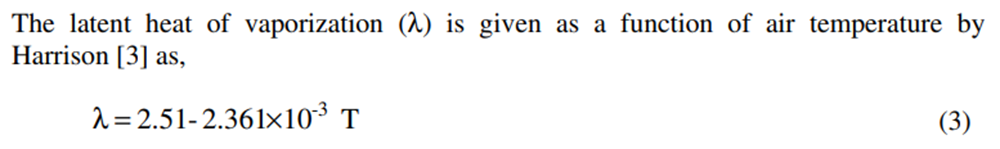

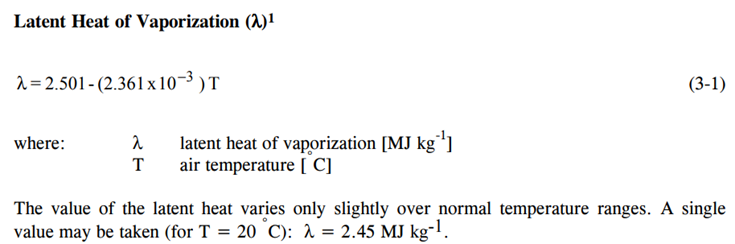

In [6]:
_lambda = 2.501 - (2.361*10**(-3))*T

# Psychrometric constant [kPa/°C]

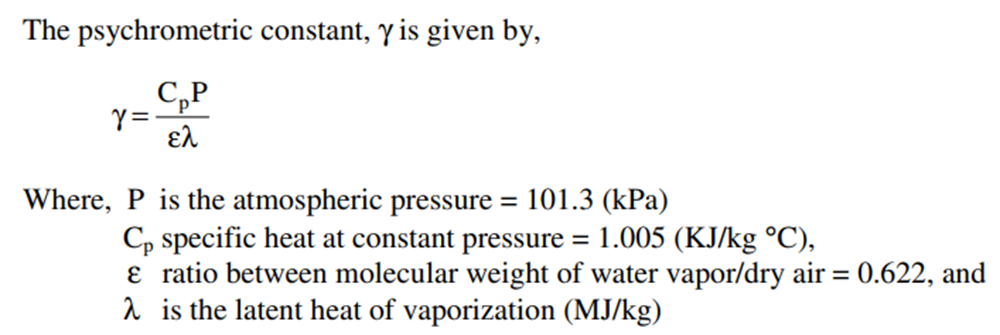

In [7]:
_gamma = (1.005*101.3)/(0.622*_lambda*10**3)

# Wind 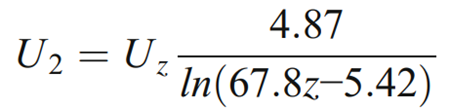

In [32]:
ds = xr.open_dataset(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\sfcWind_day_CanESM5_ssp126_r1i1p1f1_gn_2057.nc')
ds.variables#. comment:        near-surface (usually, 10 meters) wind speed

Frozen({'sfcWind': <xarray.Variable (time: 365, lat: 81, lon: 61)>
[1803465 values with dtype=float32]
Attributes:
    standard_name:  wind_speed
    long_name:      Daily-Mean Near-Surface Wind Speed
    units:          m s-1
    comment:        near-surface (usually, 10 meters) wind speed.
    original_name:  SWA
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    _ChunkSizes:    [   1  600 1440], 'time': <xarray.IndexVariable 'time' (time: 365)>
array([cftime.DatetimeNoLeap(2057, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2057, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2057, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2057, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2057, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2057, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Attributes:
    axis:                 T


In [92]:
ds = xr.open_dataset(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\rsds_day_BCC-CSM2-MR_historical_r1i1p1f1_gn_1979.nc')
ds.variables

Frozen({'rsds': <xarray.Variable (time: 365, lat: 81, lon: 61)>
[1803465 values with dtype=float32]
Attributes:
    standard_name:  surface_downwelling_shortwave_flux_in_air
    long_name:      Surface Downwelling Shortwave Radiation
    units:          W m-2
    comment:        surface solar irradiance for UV calculations
    original_name:  FSDS
    cell_methods:   area: time: mean (interval: 5 minutes)
    cell_measures:  area: areacella
    _ChunkSizes:    [   1  600 1440], 'time': <xarray.IndexVariable 'time' (time: 365)>
array([cftime.DatetimeNoLeap(1979, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1979, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1979, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1979, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1979, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1979, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
     

In [9]:
z = 10 # m
U_2 = U_z*(4.87)/(np.log(67.8*z-5.42)) # np.log is the neperian logarithm ln

# Mean saturation vapor pressure

CHECK THAT THIS IS THE MEAN

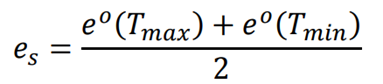
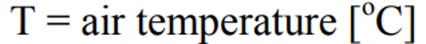
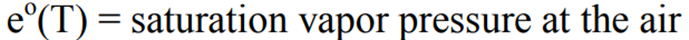

In [10]:
e_s = (e_0(T_max)+e_0(T_min))/2
e_s

4.301788106200713

# Evapotranspiration [kg.m^(-2).day^(-1)]

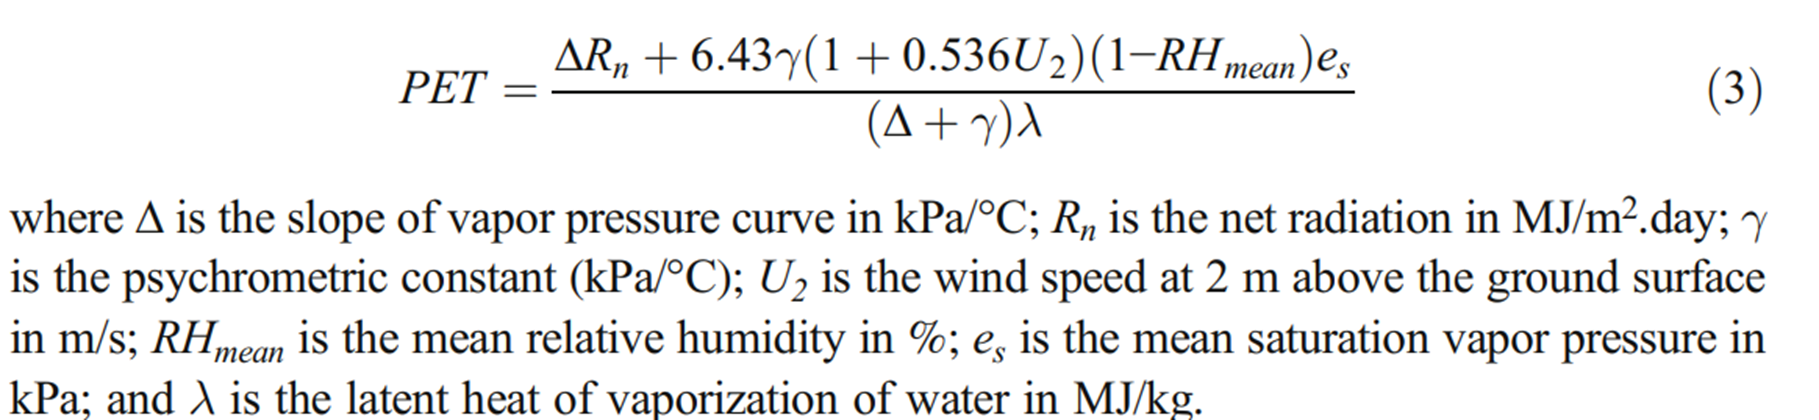

In [11]:
PET = (_delta*R_n + (6.43*_gamma*(1+0.536*U_2)*(1-RH_mean)*e_s))/((_delta+_gamma)*_lambda)

In [16]:
print('The evapotranspiration is '+str(round(PET,3))+' [kg.m^(-2).day^(-1)].')

The evapotranspiration is -16.433 [kg.m^(-2).day^(-1)].
